### Title: Parkinsons Disease Data Set

Abstract: Oxford Parkinson's Disease Detection Dataset

#### Source:

The dataset was created by Max Little of the University of Oxford, in 
collaboration with the National Centre for Voice and Speech, Denver, 
Colorado, who recorded the speech signals. The original study published the 
feature extraction methods for general voice disorders.


#### Attribute Information:

1. Matrix column entries (attributes):
2. name - ASCII subject name and recording number
3. MDVP:Fo(Hz) - Average vocal fundamental frequency
4. MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
5. MDVP:Flo(Hz) - Minimum vocal fundamental frequency
6. MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several 
7. measures of variation in fundamental frequency
8. MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
9. NHR,HNR - Two measures of ratio of noise to tonal components in the voice
10. status - Health status of the subject (one) - Parkinson's, (zero) - healthy
11. RPDE,D2 - Two nonlinear dynamical complexity measures
12. DFA - Signal fractal scaling exponent
13. spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

#### Objective:
Goal is to classify the patients into the respective labels using the attributes from
their voice recordings

## Import required libraries

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew 
import seaborn as sns
import scipy.stats
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
import warnings
import time
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#read data
#data=pd.read_csv('Data - Parkinsons')
data=pd.read_csv('Data - Parkinsons.csv')

### Step 1: Understand data

In [3]:
data.shape #(195, 24)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [4]:
#checking for missing data
data.isnull().mean()*100

name                0.0
MDVP:Fo(Hz)         0.0
MDVP:Fhi(Hz)        0.0
MDVP:Flo(Hz)        0.0
MDVP:Jitter(%)      0.0
MDVP:Jitter(Abs)    0.0
MDVP:RAP            0.0
MDVP:PPQ            0.0
Jitter:DDP          0.0
MDVP:Shimmer        0.0
MDVP:Shimmer(dB)    0.0
Shimmer:APQ3        0.0
Shimmer:APQ5        0.0
MDVP:APQ            0.0
Shimmer:DDA         0.0
NHR                 0.0
HNR                 0.0
status              0.0
RPDE                0.0
DFA                 0.0
spread1             0.0
spread2             0.0
D2                  0.0
PPE                 0.0
dtype: float64

In [5]:
#Checking sample data
data_sub= data.copy()
data_sub.sample(5)

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
94,phon_R01_S22_4,157.821,172.975,68.401,0.00358,0.00002,0.00196,0.00196,0.00587,0.03716,...,0.06185,0.00850,22.219,1,0.502380,0.712170,-6.251425,0.188056,2.143851,0.160812
120,phon_R01_S27_6,128.940,479.697,88.251,0.00581,0.00005,0.00241,0.00314,0.00723,0.02008,...,0.02548,0.02350,24.743,1,0.487756,0.684130,-6.186128,0.279933,2.686240,0.152428
154,phon_R01_S37_2,119.100,128.442,88.833,0.00692,0.00006,0.00393,0.00300,0.01179,0.02682,...,0.04451,0.04611,21.824,1,0.651680,0.659333,-4.239028,0.175691,2.451130,0.247455
148,phon_R01_S35_3,188.620,216.302,165.982,0.01719,0.00009,0.00996,0.01027,0.02987,0.07118,...,0.10422,0.08069,12.298,1,0.552870,0.764036,-3.377325,0.335357,3.274865,0.418646
60,phon_R01_S17_1,209.144,237.494,109.379,0.00282,0.00001,0.00147,0.00152,0.00442,0.01861,...,0.02925,0.00871,25.554,0,0.341788,0.678874,-7.040508,0.066994,2.460791,0.101516


Summary:
1. Data has records of 195 patients, across 23 different voice recording measures.
2. Data has no missing observations.
3. Name column has 195 unique records same as number of observations. So data has unique record per patient
4. Name of the patients wont be useful, so dropping it from further analysis
4. All other variables are either integer or float 64.
5. Converting Status to object for EDA
6. From sample data it looks like measuring scales of all attributes is varying a lot. Some attributes are measured on very small scale compared to others. Data will need to be standardize before applying ml algorithms
7. Spread1 is the single variable with negative values

### Step 2: EDA

In [6]:
# descriptive statistics of each of the attributes
pd.set_option('float_format', '{:.5f}'.format)
data_sub['status']= data_sub['status'].astype('object')
data_sub.describe(include ='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,195,195,phon_R01_S33_6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MDVP:Fo(Hz),195.00000,NaN,NaN,NaN,154.22864,41.39006,88.33300,117.57200,148.79000,182.76900,260.10500
MDVP:Fhi(Hz),195.00000,NaN,NaN,NaN,197.10492,91.49155,102.14500,134.86250,175.82900,224.20550,592.03000
MDVP:Flo(Hz),195.00000,NaN,NaN,NaN,116.32463,43.52141,65.47600,84.29100,104.31500,140.01850,239.17000
MDVP:Jitter(%),195.00000,NaN,NaN,NaN,0.00622,0.00485,0.00168,0.00346,0.00494,0.00737,0.03316
MDVP:Jitter(Abs),195.00000,NaN,NaN,NaN,0.00004,0.00003,0.00001,0.00002,0.00003,0.00006,0.00026
MDVP:RAP,195.00000,NaN,NaN,NaN,0.00331,0.00297,0.00068,0.00166,0.00250,0.00383,0.02144
MDVP:PPQ,195.00000,NaN,NaN,NaN,0.00345,0.00276,0.00092,0.00186,0.00269,0.00396,0.01958
Jitter:DDP,195.00000,NaN,NaN,NaN,0.00992,0.00890,0.00204,0.00498,0.00749,0.01150,0.06433
MDVP:Shimmer,195.00000,NaN,NaN,NaN,0.02971,0.01886,0.00954,0.01650,0.02297,0.03789,0.11908


Summary:
1. Data has no missing obervations. 
2. Scale of each attributes is varying a lot. Data will need to be scaled.
3. By overlooking 75% and Max value in summary statistics above, features are skewed. Will check distribution of each variable seperately in Univariate analysis.

Summary Statistics:

1. By compairing 75% percentile and max value, it looks like most of the variables are skewed
4. Except variables like MDVP(Flo,Fhi and Flow), D2 and HNR, are very small and closed to zero.
5. spread1 : is on negative scale with average of -5.684397
3.	Average vocal fundamental frequency: MDVP:Fo(Hz) has average frequency 154.229 HZ
4.	Maximum vocal fundamental frequency: MDVP:Fhi(Hz) has average frequency 197.105 HZ, max value looks quite deviated from 75% percentile. Data looks skewed and might have the presence of outliers
5.	Minimum vocal fundamental frequency: MDVP:Flo(Hz) has average frequency of 116.325 Hz.
6.	MDVP:Jitter(%): has a small percentage value, with average jitter(%) 0.00622046
7.	MDVP:Jitter(Abs): has a small scale compared to other variables and has an average of 0.000044
8.	MDVP:RAP: has an average of 0.003306 with SD 0.002968
9.	MDVP:PPQ :has an average of 0.003446 with SD 0.002759
10.	Jitter:DDP has an average of 0.009920 with SD 0.008903
11.	MDVP:Shimmer has an average of 0.029709 with SD 0.018857
12.	MDVP:Shimmer(dB) has an average of 0.282251 with SD 0.194877
13.	Shimmer:APQ3 has an average of 0.015664 with SD 0.010153
14.	Shimmer:APQ5 has an average of 0.017878 with SD 0.012024
15.	MDVP:APQ has an average of 0.024081 with SD 0.016947
16.	Shimmer:DDA has an average of 0.046993 with SD 0.030459
17.	NHR has an average of 0.024847 with SD 0.040418
18.	HNR has an average of 21.885974 with SD 4.425764
19.	Status has two values, 1 being most frequent, with frequency 147
20.	RPDE has an average of 0.498536 with SD 0.103942
21.	DFA has an average of 0.718099 with SD 0.055336
22.	spread1 has an average of -5.684397 with SD 1.090208
23.	spread2 has an average of 0.226510 with SD 0.083406
24.	D2 has an average of 2.381826 with SD 0.382799
25.	PPE has an average of 0.206552 with SD 0.090119

### Step 2.1: Univariate Analysis

In [7]:
#column name is dropped from analysis
if 'name' in data_sub.columns:
    data_sub=data_sub.drop(columns='name', axis=1)
    print('column name has been dropped')
else:
    print('Name of the patient does not exist')

column name has been dropped


<AxesSubplot:>

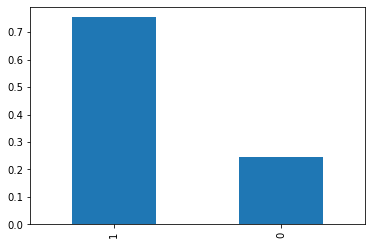

In [8]:
## Distribution of status
data_sub['status'].value_counts(normalize=True).plot(kind='bar')

In [9]:
#Distribution of attributes

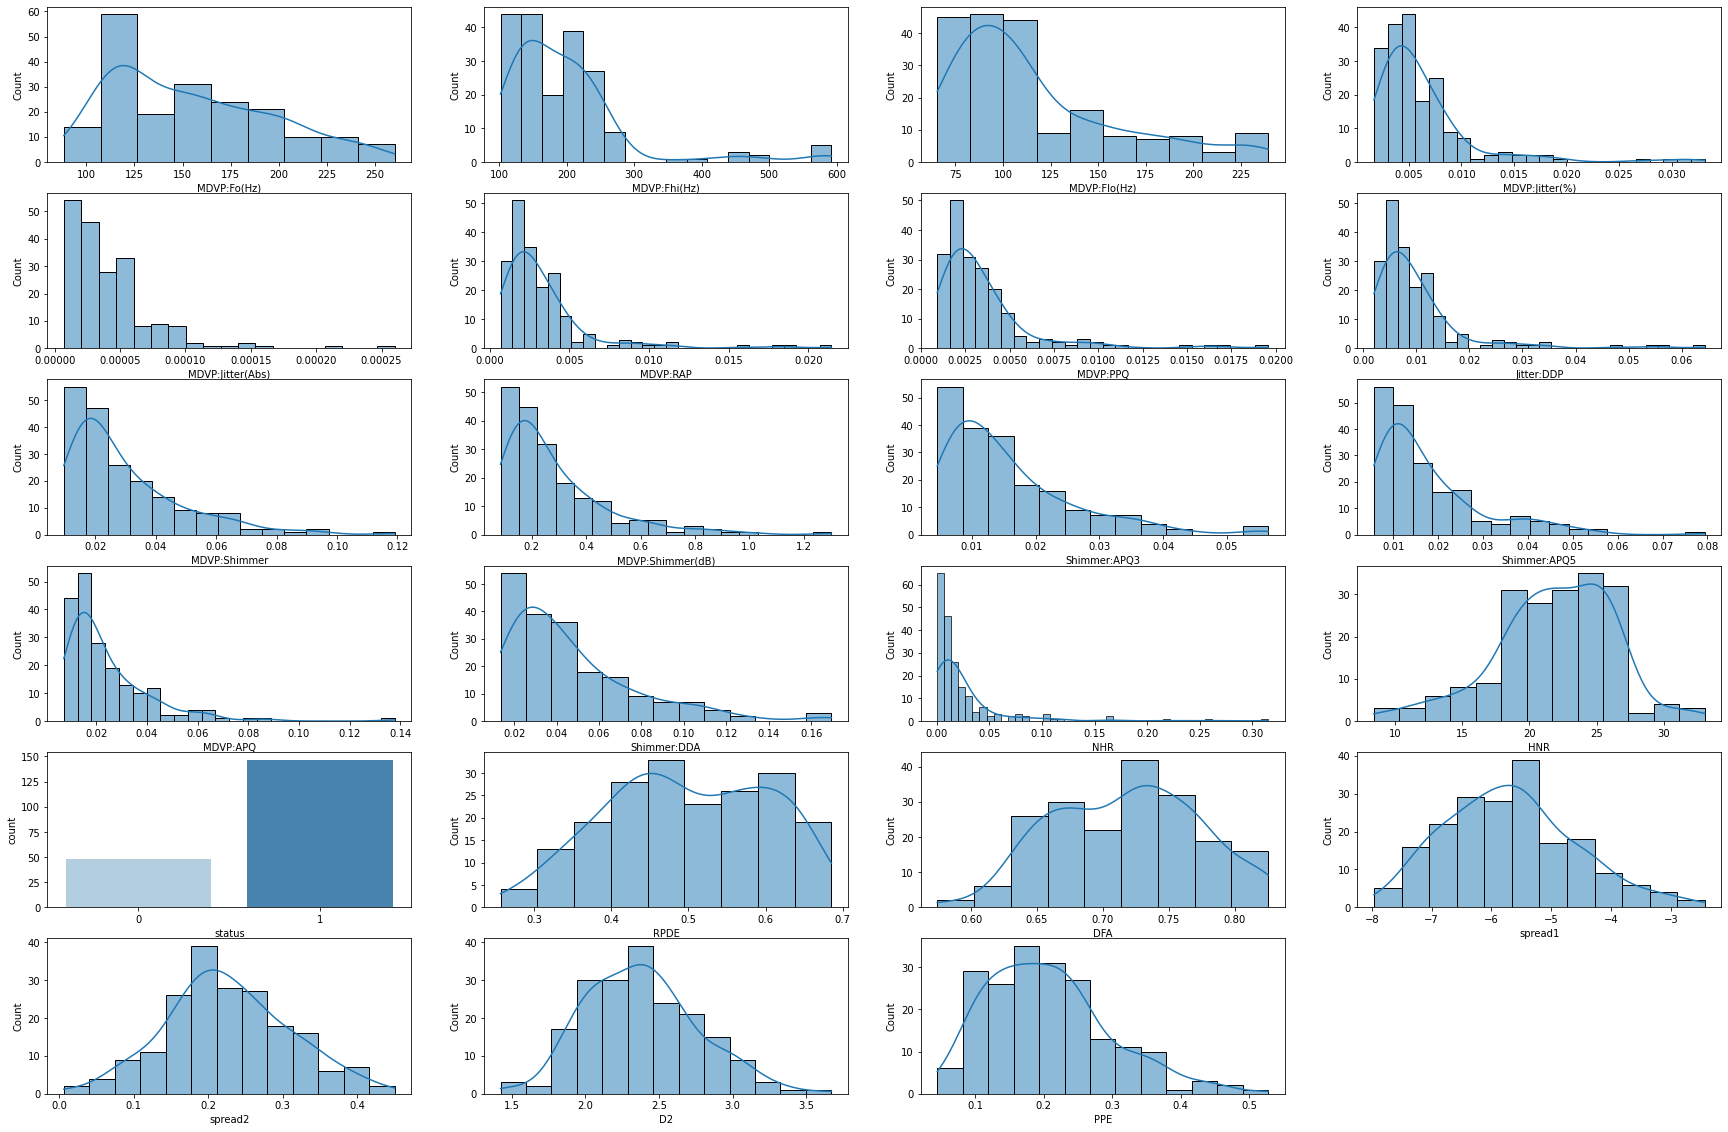

In [10]:
plt.figure(figsize= (30,20))  # Set the figure size
pos =  1   # a variable to manage the position of the subplot in the overall plot
for i in data_sub.columns:   # for-loop to iterate over every attribute whose distribution is to be visualized
    plt.subplot(6, 4, pos)   # plot grid
    if (data_sub[i].dtypes == 'int64') or (data_sub[i].dtypes == 'float64'):
        sns.histplot(data_sub[i],kde=True)
    else:
        sns.countplot(data_sub[i], palette= 'Blues')
    pos += 1  # to plot over the grid one by one  

#### Distribution plots shows most of the variables are skewed. Checking their skewness

In [11]:
#skewness analysis of features
feature=[]
skewness=[]
data_sub_skew= data_sub.drop('status', axis=1)
for i in data_sub_skew.columns:
    val=data_sub_skew[i].skew(axis = 0,skipna = True)
    feature.append(i)
    skewness.append(val)

data_skew=pd.DataFrame({'feature':feature,
                        'skewness':skewness
                       })
def skew_con(row):
    val=row['skewness']
    if val < -1.0 or val > 1.0:
        val_des='Feature is highly skewed'
    elif (val > -1.0 and val <-0.5) or (val < 1.0 and val >0.5):
        val_des='Feature is moderatly skewed'
    elif val > -0.5 or val < 0.5:
        val_des='Feature is approximately symmetric'
    return val_des

data_skew['Interpretation'] = data_skew.apply(skew_con,axis=1)

data_skew_1=data_skew[data_skew['Interpretation']!='Feature is approximately symmetric']
skewed_feature_list=data_skew_1.feature.to_list()

data_skew_2=data_skew[data_skew['Interpretation']=='Feature is approximately symmetric']
nonskewed_feature_list=data_skew_2.feature.to_list()

In [12]:
print('Summary:')
print(data_skew)
print(" ")

Summary:
             feature  skewness                      Interpretation
0        MDVP:Fo(Hz)   0.59174         Feature is moderatly skewed
1       MDVP:Fhi(Hz)   2.54215            Feature is highly skewed
2       MDVP:Flo(Hz)   1.21735            Feature is highly skewed
3     MDVP:Jitter(%)   3.08495            Feature is highly skewed
4   MDVP:Jitter(Abs)   2.64907            Feature is highly skewed
5           MDVP:RAP   3.36071            Feature is highly skewed
6           MDVP:PPQ   3.07389            Feature is highly skewed
7         Jitter:DDP   3.36206            Feature is highly skewed
8       MDVP:Shimmer   1.66648            Feature is highly skewed
9   MDVP:Shimmer(dB)   1.99939            Feature is highly skewed
10      Shimmer:APQ3   1.58058            Feature is highly skewed
11      Shimmer:APQ5   1.79870            Feature is highly skewed
12          MDVP:APQ   2.61805            Feature is highly skewed
13       Shimmer:DDA   1.58062            Feature is 

#### Univariate Data Analysis Summary :
1. status - Health status of the subject (one) - Parkinson's, (zero) - healthy
2. data has 147(75%) patients identified for Parkinson’s and 48 (25%) patients not identified as Parkinson
3. Target class is imbalanced. Models might show biasedness towards predicting more patients with Parkinson’s. So might see false positive more with prediction.
4. In this data identifying Parkinson's patients is more important so that patients can recive proper treatment. so will need to analyze the models sensitivity towards identifying disesase
4. From Distribution plot and skewness, attributes RPDE, DFA, SPREAD1 , SPREAD2, D2 looks symmetric while PPE,HNR and MDVP:Fo(Hz) audio measures looks moderately skew, while all other variables are right skewed. 
5. Overall this Data has features which are right skewed with imbalanced target classes

### Step 2.2: Bivariate Analysis

In [13]:
##Correlation between features
## Getting a list of attributes which are correlated
df=data_sub.copy()
df.drop(['status'],axis=1, inplace=True)
data_corr_val=pd.DataFrame()

def data_multicollinearity(data_for_corr):
    var1=[]
    var2=[]
    corr_var_list=[]
    data_corr_val=pd.DataFrame()
    for i in data_for_corr.columns:
        for j in data_for_corr.columns:
            if i== j:
                pass
            else:
                cor_var= data_for_corr[i].corr(data_for_corr[j],'pearson')
                var1.append(i)
                var2.append(j)
                corr_var_list.append(cor_var)
        
    data_corr_val=pd.DataFrame({'var1':var1,
                               'var2':var2,
                               'correlation':corr_var_list})
    data_corr_val=data_corr_val[(abs(data_corr_val['correlation'])> 0.85)]
    return data_corr_val
data_all=data_multicollinearity(df)
data_all

,var1,var2,correlation
66,MDVP:Jitter(%),MDVP:Jitter(Abs),0.93571
67,MDVP:Jitter(%),MDVP:RAP,0.99028
68,MDVP:Jitter(%),MDVP:PPQ,0.97426
69,MDVP:Jitter(%),Jitter:DDP,0.99028
76,MDVP:Jitter(%),NHR,0.90696
87,MDVP:Jitter(Abs),MDVP:Jitter(%),0.93571
88,MDVP:Jitter(Abs),MDVP:RAP,0.92291
89,MDVP:Jitter(Abs),MDVP:PPQ,0.89778
90,MDVP:Jitter(Abs),Jitter:DDP,0.92291
108,MDVP:RAP,MDVP:Jitter(%),0.99028


In [14]:
# relation between features and status

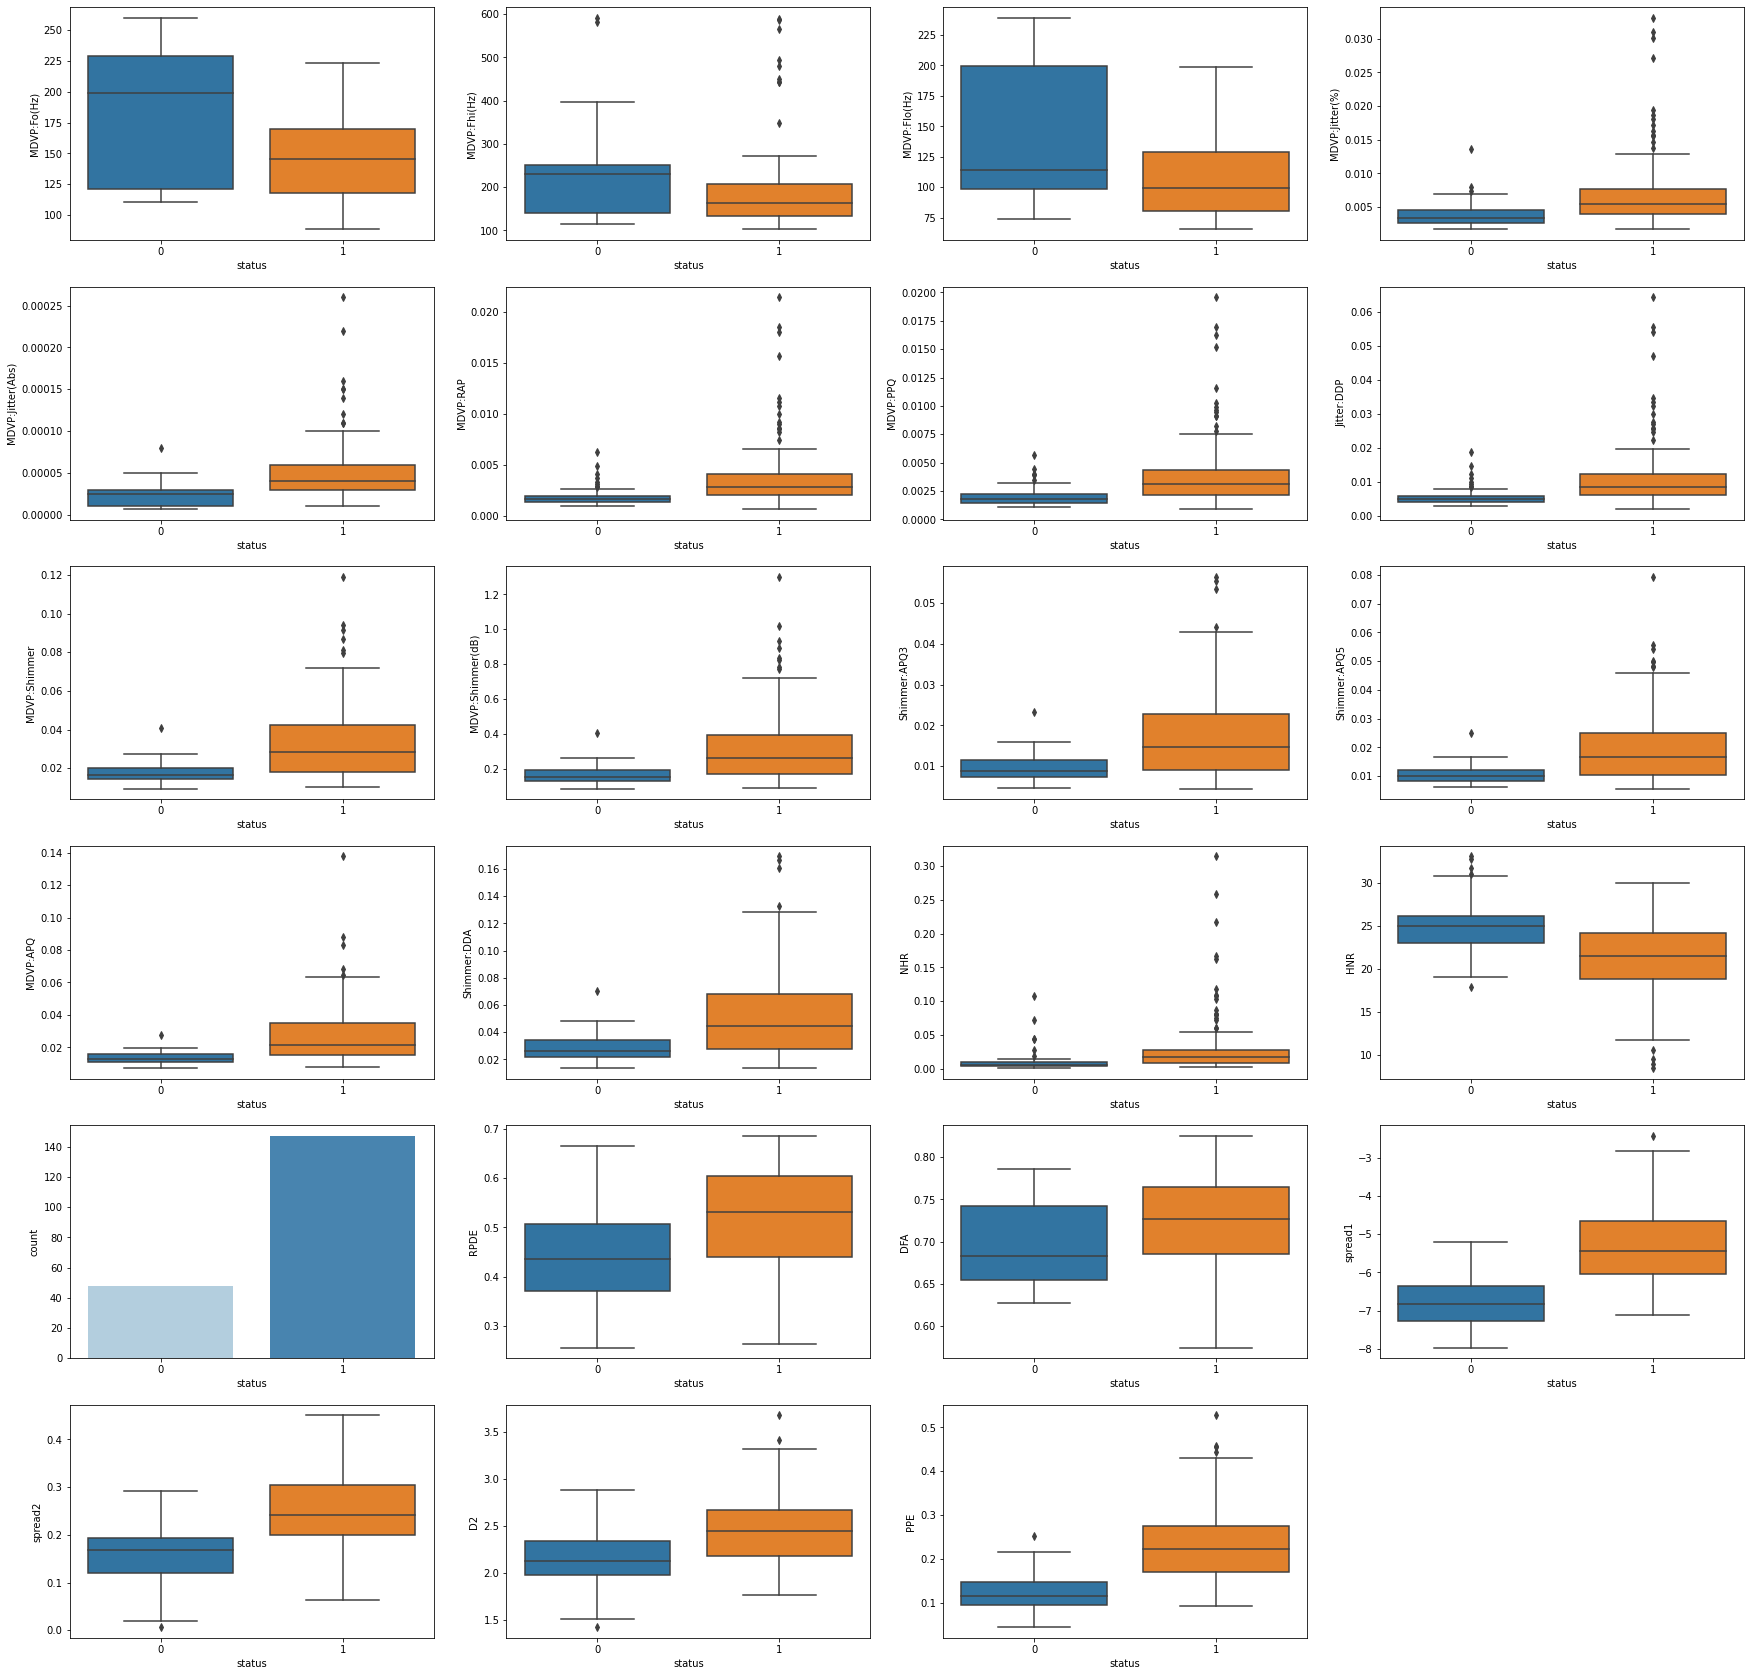

In [15]:
plt.figure(figsize=(30,30))
pos=1

for i in data_sub.columns:
    plt.subplot(6,4,pos)
    if (data_sub[i].dtypes == 'int64') or (data_sub[i].dtypes == 'float64'):
        sns.boxplot(x='status',y=i, data=data_sub)
    else:
        sns.countplot(data_sub[i], palette= 'Blues')
    pos+=1


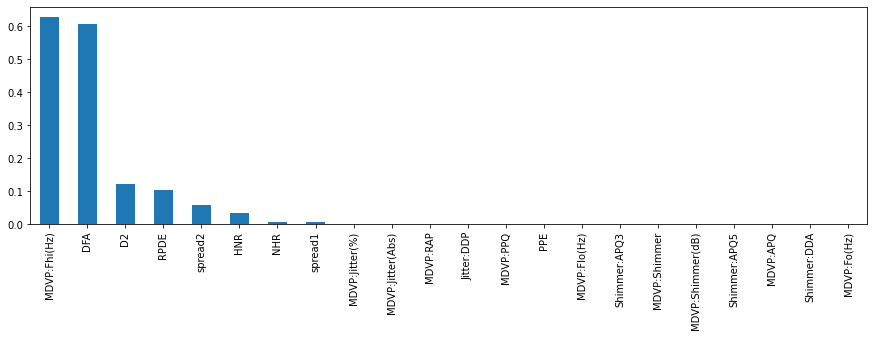

In [16]:
#since features are not normally distributed, doing leven's test to check if there is a signifiacant difference between means/distribution of features withing target class
#perfomaring test of means to check if the mean of continous variable is different for target
from scipy import stats
feature=[]
levene_p_val=[]
for i in data_sub.columns:
     if (data_sub[i].dtypes == 'int64') or (data_sub[i].dtypes == 'float64'):
            df_park=data_sub[data_sub['status']==1][i]
            df_nopark=data_sub[data_sub['status']==0][i]            
            levene_statistic, p_value=stats.levene(df_park, df_nopark, center='mean')
            feature.append(i)
            levene_p_val.append(round(p_value,4))

data_mean_test=pd.DataFrame({'feature':feature,
                             'levene_p_val':levene_p_val})
data_mean_test['Test_results']=['Reject Null hypothesis' if x < 0.05 else 'We fail to reject null hypothesis' for x in data_mean_test['levene_p_val']]

p_values = pd.Series(levene_p_val,index = feature)
p_values.sort_values(ascending = False , inplace = True)
p_values.round(5)
plt.figure(figsize=(15,4))
p_values.plot.bar();

In [17]:
print('Summary:')
print(data_mean_test)

Summary:
             feature  levene_p_val                       Test_results
0        MDVP:Fo(Hz)       0.00000             Reject Null hypothesis
1       MDVP:Fhi(Hz)       0.62710  We fail to reject null hypothesis
2       MDVP:Flo(Hz)       0.00000             Reject Null hypothesis
3     MDVP:Jitter(%)       0.00210             Reject Null hypothesis
4   MDVP:Jitter(Abs)       0.00150             Reject Null hypothesis
5           MDVP:RAP       0.00140             Reject Null hypothesis
6           MDVP:PPQ       0.00030             Reject Null hypothesis
7         Jitter:DDP       0.00140             Reject Null hypothesis
8       MDVP:Shimmer       0.00000             Reject Null hypothesis
9   MDVP:Shimmer(dB)       0.00000             Reject Null hypothesis
10      Shimmer:APQ3       0.00000             Reject Null hypothesis
11      Shimmer:APQ5       0.00000             Reject Null hypothesis
12          MDVP:APQ       0.00000             Reject Null hypothesis
13       Sh

### Summary of Bivariate Analysis:
1. From boxplot it can be observed that for all features, distribution of patients with Parkinson and without Parkinson is different 
2. From mean test it looks like, the difference between the means of numeric attributes for both the target classes is statistically significant. Except for MDVP:Fhi(Hz), RPDE, DFA, Spread2 and D2 features. Other variables shows some variation as target class changes so can be used for prediction.
4. From Bivariate correlation table, we can also observe that features are also correlated with each other, showing presence of multicollinearity within data

## Step 2.3: Multivariate Analysis

<Figure size 7200x7200 with 0 Axes>

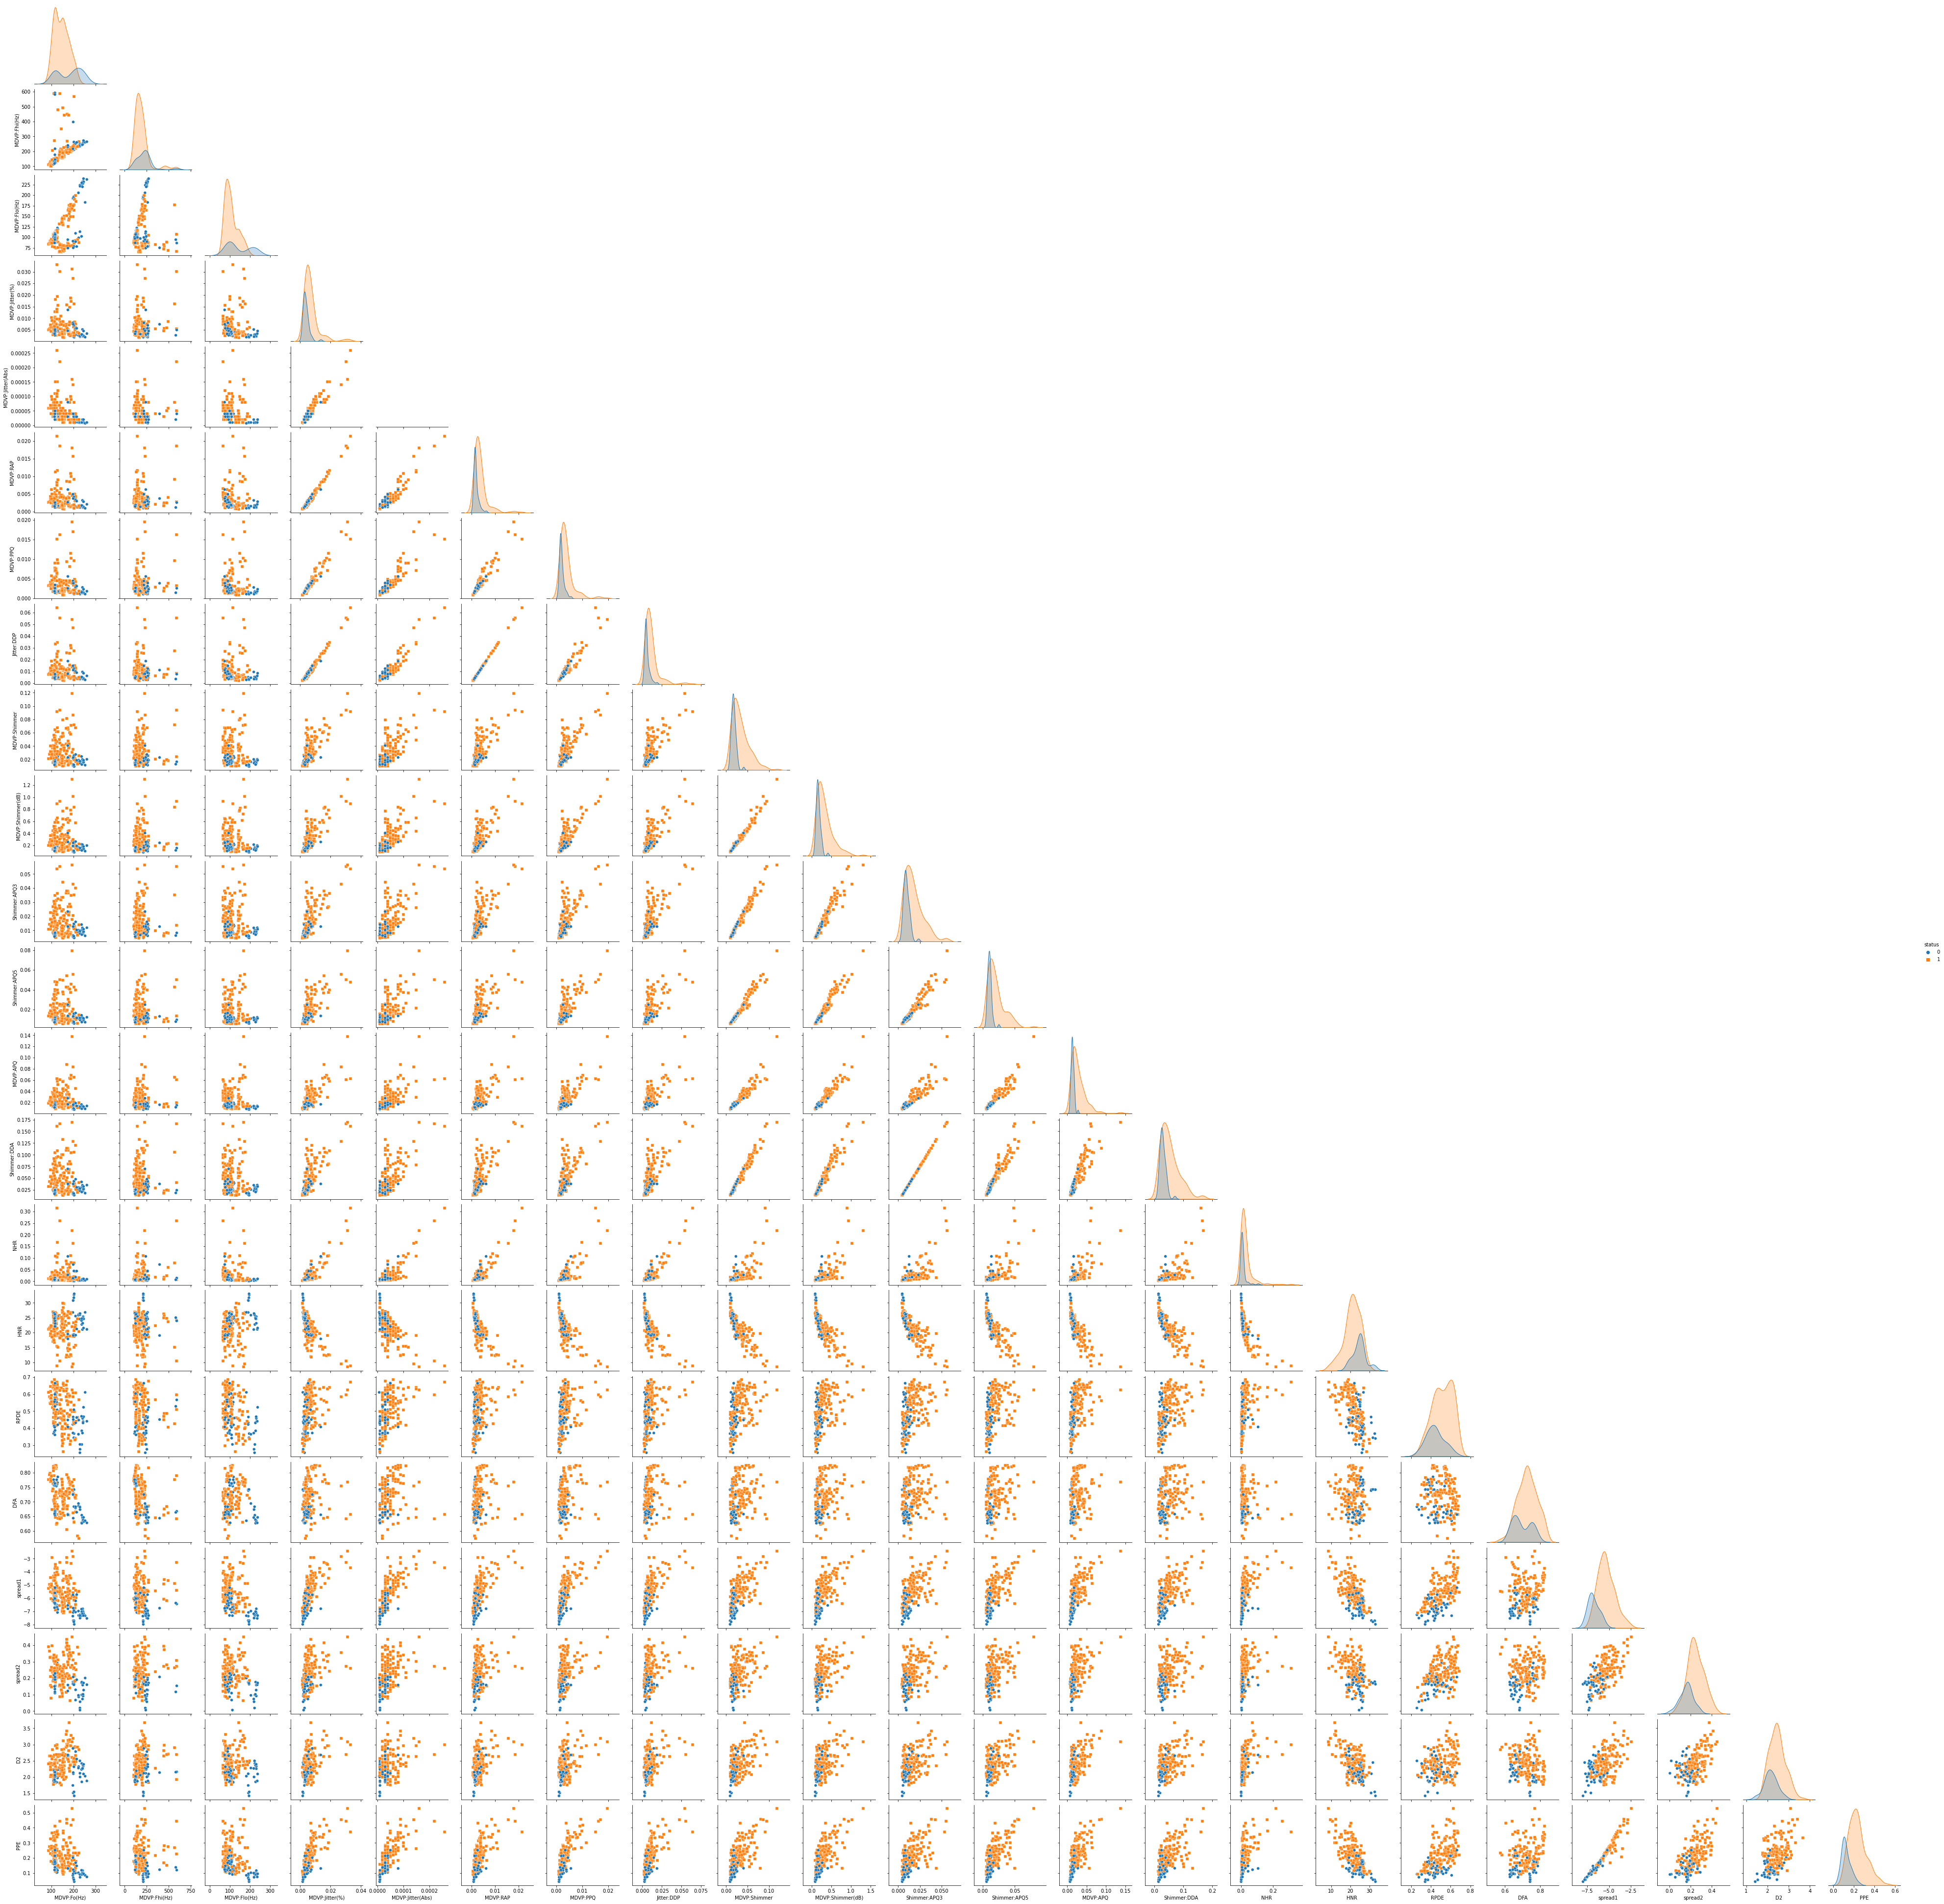

In [18]:
plt.figure(figsize=(100,100))
sns.pairplot(data, hue='status',markers=["o", "s"], corner=True); # Get only lower triangle

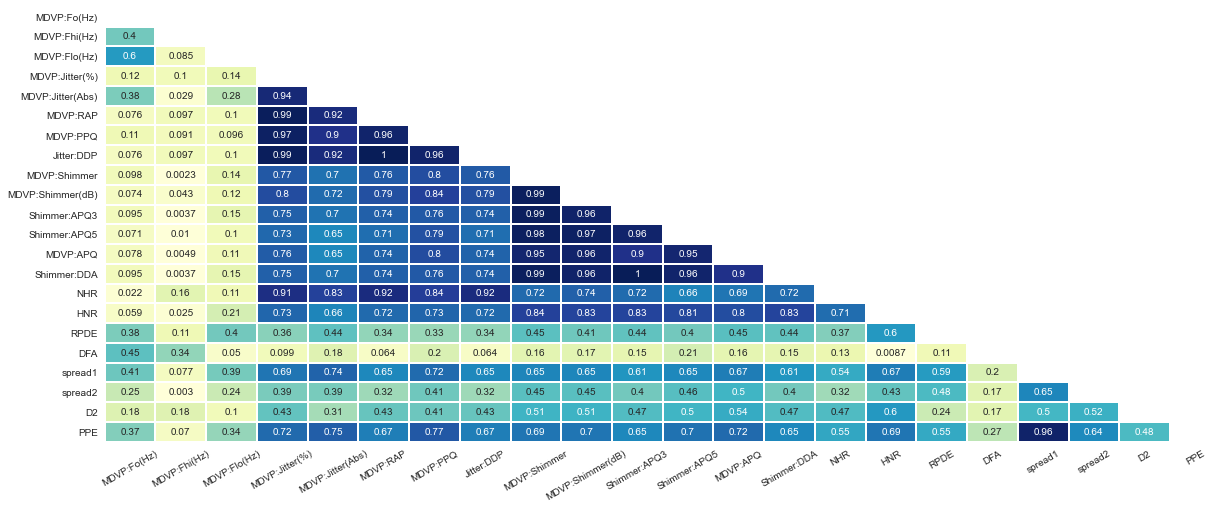

In [19]:
corr = abs(data_sub.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (20,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= "YlGnBu", annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask)   # Da Heatmap
plt.xticks(rotation = 30)   # Aesthetic purposes
#plt.yticks(rotation = 10)   # Aesthetic purposes
plt.show()

Summary:
1. From the diagonal plots of Pariplot we can see that distribution of target class is overlapping. And the target points are clustered when compared with other variables. 
2. Since we see the clusters of target class in pairplot, it looks like it might be difficult to separate this data with linear boundaries.
3. Pairplot and correlation  also shows strong linear relationship within features. Both Positive and negative relations can be observed.
3. Overall, data has imbalanced Target class, with skewed features which are correlated with each other showing multicollinearity

### Step 3: Data Preprocessing

Methodology:
1. The data has imbalanced Target class, with skewed and multicollinear variables.
2. So in data pre processing all the features have been standardize
3. Since data has imbalanced class, have up sampled the data in data pre-processing.
6. As data shows multicollinearity, have also tried feature importance and checked the ML performance

#### Step 3.1 : Dropping Target variable and feature 'name' from feature space

In [20]:
## Creating new copy of parkinson's data by dropping redundant variable and target to segregate fetures and target variable
drop_list=['status','name']

if set(drop_list).issubset(data.columns):
    data_x=data.drop(drop_list, axis=1)
    print('Columns from drop list has been removed')
else:
    print("Columns in drop list does not exist")

Columns from drop list has been removed


#### Step 3.2 : Scaling all features as they are in different scales -Standard Scaling

In [21]:
## Standard Scaling
from sklearn.preprocessing import StandardScaler
sca=StandardScaler()

X_std_sca=pd.DataFrame(sca.fit_transform(data_x),index=data_x.index, columns=data_x.columns)
y=data['status']

X_train_sca, X_test_sca, y_train_sca, y_test_sca = train_test_split(X_std_sca, y, test_size=0.3,stratify=y, random_state=42) # using stratify tfor imbalanced classes

#validation Check
if len(X_train_sca)+len(X_test_sca) == len(X_std_sca):
    print("Split is fine")
else:
    print("Split is not correct")

Split is fine


#### Step 3.3: upsampling for imblanaced target varible

In [22]:
from sklearn.utils import resample

#using scaled data for upsampling
mask= y_train_sca==0
no_park_df= y_train_sca[mask]
park_df= y_train_sca[~mask]

extra_sample_size= len(park_df)-len(no_park_df) # extra samples same as the lag
extra_samples = y_train_sca[y_train_sca == 0].sample(n=extra_sample_size,replace = True, random_state=56).index # Generate duplicate samples index

y_train_upsample = y_train_sca.append(y_train_sca.loc[extra_samples])  # use the index of the duplicate samples to append to the y_train
print("Shape of upsampled target data:",(y_train_upsample.shape))

extra_samples_x = X_train_sca.loc[extra_samples]   # use the same index to generate duplicate rows in X_train
X_train_upsample = X_train_sca.append(extra_samples_x)  #
print("shape of upsampled feature data:",(X_train_upsample.shape))

print(y_train_upsample.value_counts(normalize=True))

## Validation data
X_train_v1=X_train_upsample
print("Shape of upsampled Train feature data:",(X_train_v1.shape))
y_train_v1=y_train_upsample
print("Shape of upsampled Train target data:",(y_train_v1.shape))
X_test_v1=X_test_sca
print("Shape test feature data:",(X_test_v1.shape))
y_test_v1=y_test_sca
print("Shape test target data:",(y_test_v1.shape))

Shape of upsampled target data: (206,)
shape of upsampled feature data: (206, 22)
1   0.50000
0   0.50000
Name: status, dtype: float64
Shape of upsampled Train feature data: (206, 22)
Shape of upsampled Train target data: (206,)
Shape test feature data: (59, 22)
Shape test target data: (59,)


### Step 4: Modelling 

#### Step 4.1: Create a function for model training

In [23]:
## Function to fit the model and predict on test and calculate matrices
## Execute model in sequence 

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
import pylab as pl

def train_test_fit(model, X_train, X_test, y_train, y_test): 
    start = time.time()
    model.fit(X_train, y_train)   # fit the model with the train data
    y_pred = model.predict(X_test)  # make predictions on the test set
    score = round(model.score(X_test, y_test), 3)   # compute accuracy score for test set
    
    recall=metrics.recall_score(y_test, y_pred)
    precision=metrics.precision_score(y_test, y_pred)
    f1_score= round(metrics.f1_score(y_test, y_pred),3)
    
    probas_ = model.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = round(auc(fpr, tpr),3)
    end = time.time()
    duration = end - start  # calculate the total duration
    
    return y_pred,score, recall, precision,f1_score,roc_auc,fpr, tpr,duration   # return all the metrics

def model_training(classfierdict, X_train, X_test, y_train, y_test,iteration_det):
    scoring_metric=pd.DataFrame()
    scoring_metric_fl=pd.DataFrame()
    model_name_list= []
    score_list = []
    recall_list=[]
    precision_list=[]
    f1_score_list=[]
    roc_auc_list=[]
    elapsed=[]
    y_pred_list=[]
    cm=[]
    
    for i in classfierdict['model']:
        y_pred,score, recall, precision,f1_score,roc_auc,fpr, tpr,duration=train_test_fit(i,X_train, X_test, y_train, y_test)
        y_pred_list.append(y_pred)
        model_name_list.append(i)
        score_list.append(score)
        recall_list.append(recall)
        precision_list.append(precision)
        f1_score_list.append(f1_score)
        roc_auc_list.append(roc_auc)
        elapsed.append(duration)
        Model_name='model'+'_'+re.sub("[\(\[].*?[\)\]]", "", str(i))        
        cm=metrics.confusion_matrix(y_test, y_pred, labels=[1, 0])
        df_cm = pd.DataFrame(cm, index = [j for j in ["1","0"]],columns = [j for j in ["Predict 1","Predict 0"]])
        plt.figure(figsize = (7,5))
        print("Confusion Matrix of",Model_name,"with", iteration_det)
        sns.heatmap(df_cm, annot=True,fmt='g',annot_kws={"fontsize":10})
        plt.show()
        
    scoring_metric = pd.DataFrame({'iteration': iteration_det,
                                   'Model':model_name_list,
                                   'Model_score':score_list,
                                   'Model_recall':recall_list,
                                   'Model_precision':precision_list,
                                   'Model_f1_score':f1_score_list,
                                   'Model_roc_auc':roc_auc_list,
                                   'Elapsed': elapsed})
    scoring_metric['Model_name']= scoring_metric['Model'].astype('str').map(lambda x:re.sub("[\(\[].*?[\)\]]", "", x))   
    return scoring_metric  # return all the metrics

### Step 4.1 : Modelling with upsampling

In [24]:
#hyperparameter tunning for SVC
from sklearn.svm import SVC

svc = SVC()

parameters = {
              'kernel' :['poly', 'rbf', 'sigmoid'], 
              'C': [0.1, 0.4, 0.8, 1, 2, 5,10,20,30]
              }

grid_search=GridSearchCV(estimator=svc ,param_grid=parameters,cv=10,n_jobs=-1,verbose=2)
grid_search.fit(X_train_v1,y_train_v1)

print(grid_search.best_params_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s


{'C': 20, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    3.6s finished


In [25]:
#hyperparameter tunning for KNN
KNN= KNeighborsClassifier(n_neighbors=3,weights='distance')

parameters = {
              'n_neighbors': [3,5,7,11,15]
              }

grid_search=GridSearchCV(estimator=KNN,param_grid=parameters,cv=10,n_jobs=-1,verbose=2)
grid_search.fit(X_train_v1,y_train_v1)

print(grid_search.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 5 candidates, totalling 50 fits
{'n_neighbors': 3}


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


Confusion Matrix of model_GaussianNB with Upsampling


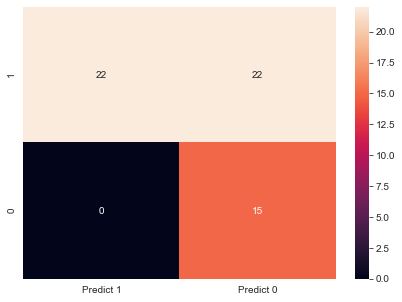

Confusion Matrix of model_LogisticRegression with Upsampling


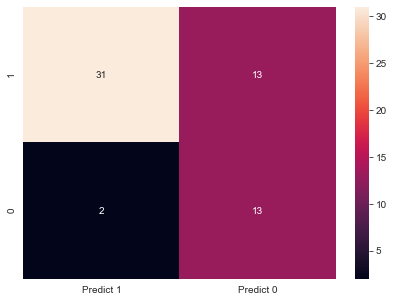

Confusion Matrix of model_KNeighborsClassifier with Upsampling


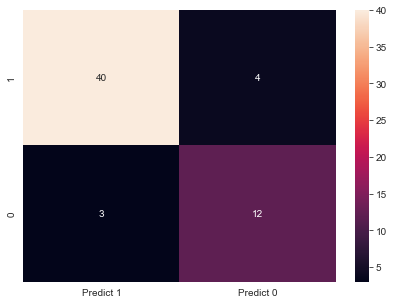

Confusion Matrix of model_SVC with Upsampling


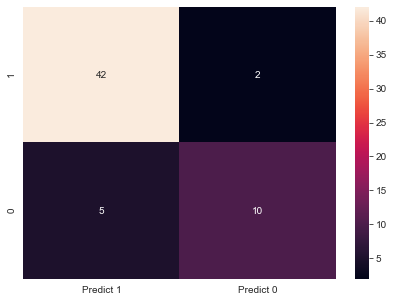

,iteration,Model,Model_score,Model_recall,Model_precision,Model_f1_score,Model_roc_auc,Elapsed,Model_name
0,Upsampling,GaussianNB(),0.62700,0.50000,1.00000,0.66700,0.85200,0.01658,GaussianNB
1,Upsampling,LogisticRegression(solver='liblinear'),0.74600,0.70455,0.93939,0.80500,0.87400,0.02488,LogisticRegression
2,Upsampling,"KNeighborsClassifier(n_neighbors=3, weights='d...",0.88100,0.90909,0.93023,0.92000,0.94300,0.03985,KNeighborsClassifier
3,Upsampling,"SVC(C=20, probability=True)",0.88100,0.95455,0.89362,0.92300,0.94400,0.05105,SVC


In [26]:
#Individual Model Performance
classfierdict={'model': [GaussianNB(),
                         LogisticRegression(solver='liblinear'),
                         KNeighborsClassifier(n_neighbors=3,weights='distance'),
                         SVC(C=20, kernel='rbf',probability=True)]}

data_1=model_training(classfierdict,X_train_v1, X_test_v1, y_train_v1, y_test_v1,'Upsampling')
data_1.sort_values(by='Model_roc_auc', axis=0)

Summary:
1. In this iteration, all the variables are scaled and data has been up sampled for Minority class
2. Here Both SVM and KNN have performed well with AUC 94.3 & 94.4 respectively. Both the models have same accuracy
3. From pair plot we saw the clusters of target class distributed across variables, for the same reason the models linear boundaries like Logistic an NB has not performed well. 
4. Looks like KNN worked well due to closed clusters.
5. SVM has performed well with RBF Kernel
6. While comparing confusion matrix for SVM and KNN, we can see that SVM has performed well in identifying patients with Parkinson's disease as it has more TP and less FN. But also shows bit high FP compared to KNN model.
7. KNN model has good accuracy, but also has more FN, with this patients with disease wont be able identified for treatment

### Step 4.2 : Stacking Classfier with Standardize data all variable with upsampling

In [27]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
sca=StandardScaler()

# X_stack=pd.DataFrame(sca.fit_transform(data_x),index=data_x.index, columns=data_x.columns)
# y_stack=data['status']
list_of_models=[
               ('DTree',DecisionTreeClassifier()),
               ('KNN',KNeighborsClassifier( n_neighbors=3,weights='distance')),
               ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
               ('svr', SVC(C=20, kernel='rbf',probability=True,random_state=42))
               ]

clf = StackingClassifier(estimators=list_of_models, final_estimator=LogisticRegression(), cv=10)

Confusion Matrix of model_StackingClassifier(cv=10,
                   estimators=),
                               ('KNN',
                                KNeighborsClassifier(n_neighbors=3,
                                                     weights='distance')),
                               ('rf',
                                RandomForestClassifier(n_estimators=50,
                                                       random_state=42)),
                               ('svr',
                                SVC)],
                   final_estimator=LogisticRegression) with Stacking with upsampling


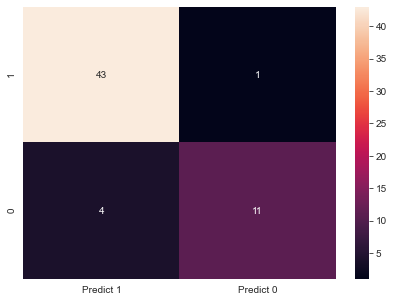

,iteration,Model,Model_score,Model_recall,Model_precision,Model_f1_score,Model_roc_auc,Elapsed,Model_name
0,Stacking with upsampling,"StackingClassifier(cv=10,\n ...",0.91500,0.97727,0.91489,0.94500,0.95800,2.49973,"StackingClassifier(cv=10,\n ..."


In [28]:
#Model Performance
classfierdict={'model': [clf]}

data_2=model_training(classfierdict,X_train_v1, X_test_v1, y_train_v1, y_test_v1,'Stacking with upsampling')
data_2.sort_values(by='Model_roc_auc', axis=0)

Summary:
1. With Stacking, overall model accuracy has improved than individual models from last iteration, also shows improvement in f1-score and auc.
2. Model has shown quite an improvement in identifying True Parkinson's patients with high TP and less False Negative. 
3. Model also shows biasedness towards identifying Positive case as a result we see more FP

### Step 4.3: Random Forest ( Homogenous Ensemble)

Step 1: finding optimum value of hyperparameter with grid search cv

In [29]:

random_forest= RandomForestClassifier()
parms={
      "n_estimators":[50,150],
      "max_features":[5,'auto'],
      "min_samples_leaf":[2,5,0.1],
      "random_state":[56]
       
      }
cv= GridSearchCV(random_forest,parms, n_jobs=-1,scoring="roc_auc").fit(X_train_v1,y_train_v1) #n_jobs to allow parralel processsing

In [30]:
print(cv.best_params_)
max_features=cv.best_params_['max_features']
min_samples_leaf=cv.best_params_['min_samples_leaf']
n_estimators=cv.best_params_['n_estimators']
random_state=cv.best_params_['random_state']
max_features

{'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 150, 'random_state': 56}


5

Confusion Matrix of model_RandomForestClassifier(max_features=5, min_samples_leaf=2, n_estimators=150,
                       random_state=56) with Random Forest


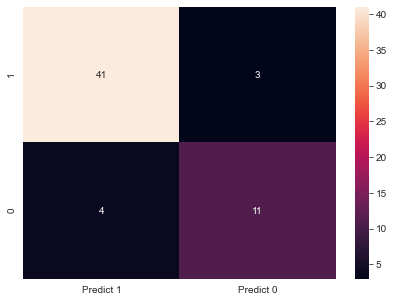

,iteration,Model,Model_score,Model_recall,Model_precision,Model_f1_score,Model_roc_auc,Elapsed,Model_name
0,Random Forest,"(DecisionTreeClassifier(max_features=5, min_sa...",0.88100,0.93182,0.91111,0.92100,0.93800,0.52736,"RandomForestClassifier(max_features=5, min_sam..."


In [31]:
rf_model=RandomForestClassifier(max_features= max_features, min_samples_leaf= min_samples_leaf, n_estimators=n_estimators, random_state=random_state)
classfierdict={'model': [rf_model]}


data_3=model_training(classfierdict,X_train_v1, X_test_v1, y_train_v1, y_test_v1,'Random Forest')
data_3.sort_values(by='Model_roc_auc', axis=0)

Summary:
1. Random Forest has performed well to identify patients with and without Parkinson's disease.
2. Has an accuracy of 88% with AUC 93% with f1-score 0.94.
3. In Confusion matrix, we can see that there are more False negative compared to stacking this model has performed well on identifying non Parkinson’s patients too.

### Step 4.4: Ensemble Learning - Bagging

Confusion Matrix of model_BaggingClassifier with Bagging


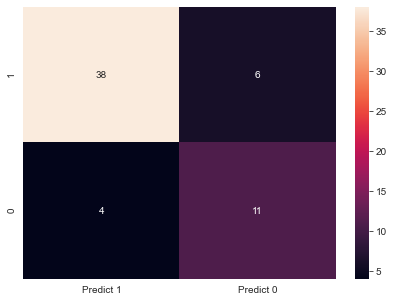

,iteration,Model,Model_score,Model_recall,Model_precision,Model_f1_score,Model_roc_auc,Elapsed,Model_name
0,Bagging,(DecisionTreeClassifier(random_state=102886208...,0.83100,0.86364,0.90476,0.88400,0.90700,0.30702,BaggingClassifier


In [32]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=50,random_state=1)

classfierdict={'model': [bgcl]}


data_8=model_training(classfierdict,X_train_v1, X_test_v1, y_train_v1, y_test_v1,'Bagging')
data_8.sort_values(by='Model_roc_auc', axis=0)

Summary:
1. Bagging shows accuracy of 83% with f1 score 88%
2. Bagging has more Parkinson's patients incorrectly identified than any other model.  Since False Negative is high this will risk health of Parkinson’s patients

### Step 4.5: Ensemble Learning - AdaBoosting

Confusion Matrix of model_AdaBoostClassifier with Adaboosting


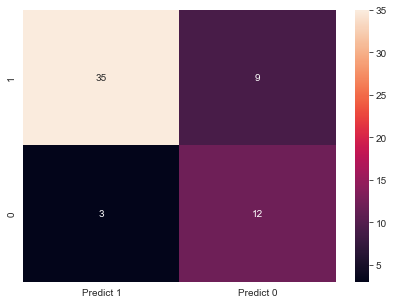

,iteration,Model,Model_score,Model_recall,Model_precision,Model_f1_score,Model_roc_auc,Elapsed,Model_name
0,Adaboosting,"(DecisionTreeClassifier(max_depth=1, random_st...",0.79700,0.79545,0.92105,0.85400,0.92900,0.06807,AdaBoostClassifier


In [33]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(n_estimators=10, random_state=1)

classfierdict={'model': [abcl]}

data_8=model_training(classfierdict,X_train_v1, X_test_v1, y_train_v1, y_test_v1,'Adaboosting')
data_8.sort_values(by='Model_roc_auc', axis=0)

### Step 4.9: Ensemble Learning - GradientBoosting

Confusion Matrix of model_GradientBoostingClassifier with GradientBoosting


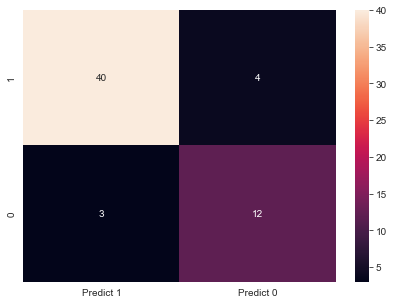

,iteration,Model,Model_score,Model_recall,Model_precision,Model_f1_score,Model_roc_auc,Elapsed,Model_name
0,GradientBoosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.88100,0.90909,0.93023,0.92000,0.94100,0.18384,GradientBoostingClassifier


In [34]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50,random_state=1)
classfierdict={'model': [gbcl]}


data_9=model_training(classfierdict,X_train_v1, X_test_v1, y_train_v1, y_test_v1,'GradientBoosting')
data_9.sort_values(by='Model_roc_auc', axis=0)

Summary:
1. Compairing ADA Boosting and Gradient Boosting, Gradient boosting seems to have performed well here.
2. which has better AUC and able to clasify patients correctly

### Step 5: model comparision

In [35]:
from sklearn.metrics import roc_curve, auc

In [75]:
## Compairing best perfomance models from each iterations
classifier1 = KNeighborsClassifier(n_neighbors=3,weights='distance')
classifier2 = SVC(C=20, kernel='rbf',probability=True)
classifier3 = StackingClassifier(estimators=list_of_models, final_estimator=LogisticRegression(), cv=10)
classifier4 = RandomForestClassifier(max_features= max_features, min_samples_leaf= min_samples_leaf, n_estimators=n_estimators, random_state=random_state)
classifier5 = GradientBoostingClassifier(n_estimators = 50,random_state=1)
classifier6 = GaussianNB()
classifier7 = LogisticRegression(solver='liblinear')
probas1_ = classifier1.fit(X_train_v1, y_train_v1).predict_proba(X_test_v1)
probas2_ = classifier2.fit(X_train_v1, y_train_v1).predict_proba(X_test_v1)
probas3_ = classifier3.fit(X_train_v1, y_train_v1).predict_proba(X_test_v1)
probas4_ = classifier4.fit(X_train_v1, y_train_v1).predict_proba(X_test_v1)
probas5_ = classifier5.fit(X_train_v1, y_train_v1).predict_proba(X_test_v1)
probas6_ = classifier6.fit(X_train_v1, y_train_v1).predict_proba(X_test_v1)
probas7_ = classifier7.fit(X_train_v1, y_train_v1).predict_proba(X_test_v1)

In [76]:
### getting roc_auc
fpr1, tpr1, thresholds1 = roc_curve(y_test_v1, probas1_[:, 1])
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, thresholds2 = roc_curve(y_test_v1, probas2_[:, 1])
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, thresholds3 = roc_curve(y_test_v1, probas3_[:, 1])
roc_auc3 = auc(fpr3, tpr3)
fpr4, tpr4, thresholds4 = roc_curve(y_test_v1, probas4_[:, 1])
roc_auc4 = auc(fpr4, tpr4)
fpr5, tpr5, thresholds5 = roc_curve(y_test_v1, probas5_[:, 1])
roc_auc5 = auc(fpr5, tpr5)
fpr6, tpr6, thresholds6 = roc_curve(y_test_v1, probas6_[:, 1])
roc_auc6 = auc(fpr6, tpr6)
fpr7, tpr7, thresholds7 = roc_curve(y_test_v1, probas7_[:, 1])
roc_auc7 = auc(fpr7, tpr7)

In [38]:
import pylab as pl

<Figure size 432x288 with 0 Axes>

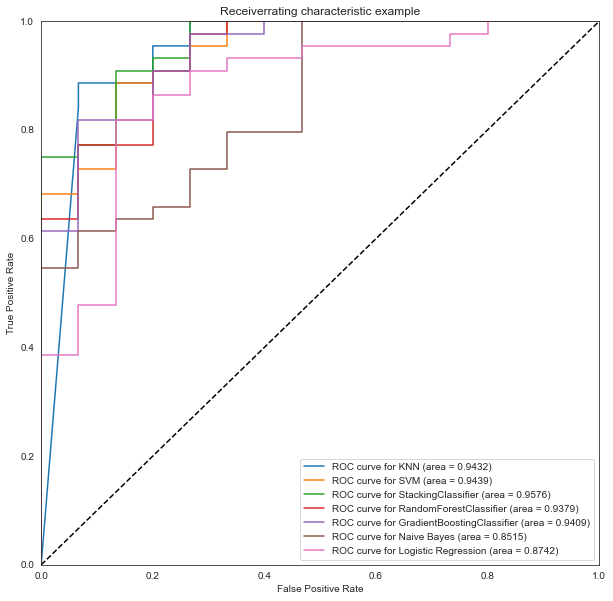

In [77]:
#Plot ROC curve
pl.clf()
plt.figure(figsize=(10,10))
pl.plot(fpr1, tpr1, label='ROC curve for KNN (area = %0.4f)' % roc_auc1)
pl.plot(fpr2, tpr2, label='ROC curve for SVM (area = %0.4f)' % roc_auc2)
pl.plot(fpr3, tpr3, label='ROC curve for StackingClassifier (area = %0.4f)' % roc_auc3)
pl.plot(fpr4, tpr4, label='ROC curve for RandomForestClassifier (area = %0.4f)' % roc_auc4)
pl.plot(fpr5, tpr5, label='ROC curve for GradientBoostingClassifier (area = %0.4f)' % roc_auc5)
pl.plot(fpr6, tpr6, label='ROC curve for Naive Bayes (area = %0.4f)' % roc_auc6)
pl.plot(fpr7, tpr7, label='ROC curve for Logistic Regression (area = %0.4f)' % roc_auc7)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiverrating characteristic example')
pl.legend(loc="lower right")
pl.show()

Confusion Matrix of  StackingClassifier(cv=10,
                   estimators=[('DTree', DecisionTreeClassifier()),
                               ('KNN',
                                KNeighborsClassifier(n_neighbors=3,
                                                     weights='distance')),
                               ('rf',
                                RandomForestClassifier(n_estimators=50,
                                                       random_state=42)),
                               ('svr',
                                SVC(C=20, probability=True, random_state=42))],
                   final_estimator=LogisticRegression())


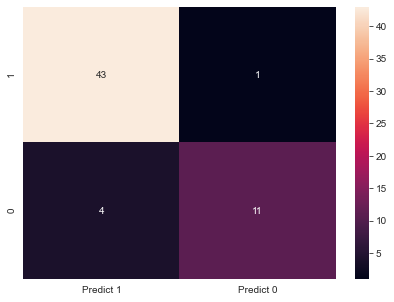

Accuracy of model is 0.915
f1_score for model is 0.945
precision for model is 0.915
Recall for model is 0.977
roc_auc_score for model is 0.8553
********************
Confusion Matrix of  GaussianNB()


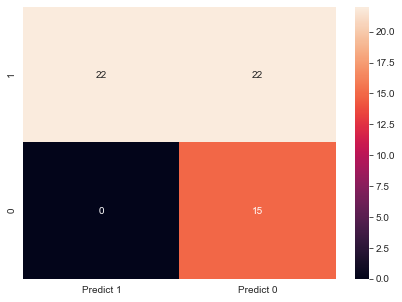

Accuracy of model is 0.627
f1_score for model is 0.667
precision for model is 1.0
Recall for model is 0.5
roc_auc_score for model is 0.75
********************
Confusion Matrix of  LogisticRegression(solver='liblinear')


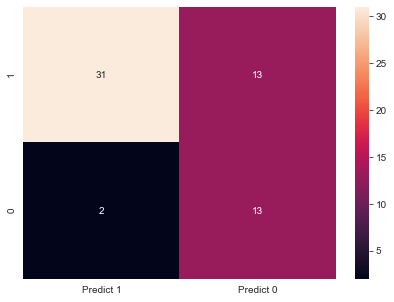

Accuracy of model is 0.746
f1_score for model is 0.805
precision for model is 0.939
Recall for model is 0.705
roc_auc_score for model is 0.7856
********************
Confusion Matrix of  KNeighborsClassifier(n_neighbors=3, weights='distance')


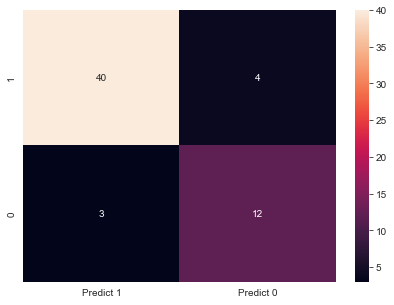

Accuracy of model is 0.881
f1_score for model is 0.92
precision for model is 0.93
Recall for model is 0.909
roc_auc_score for model is 0.8545
********************
Confusion Matrix of  SVC(C=20, probability=True)


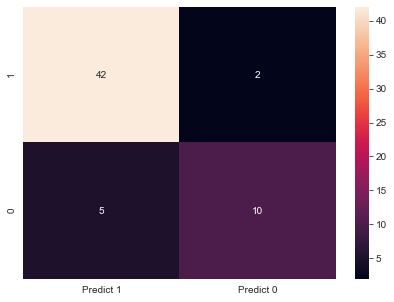

Accuracy of model is 0.881
f1_score for model is 0.923
precision for model is 0.894
Recall for model is 0.955
roc_auc_score for model is 0.8106
********************
Confusion Matrix of  RandomForestClassifier(max_features=5, min_samples_leaf=2, n_estimators=150,
                       random_state=56)


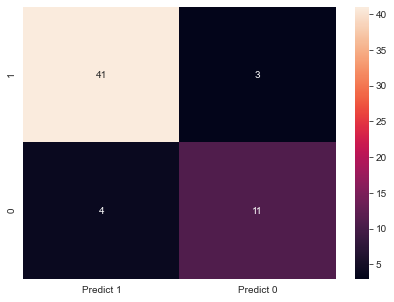

Accuracy of model is 0.881
f1_score for model is 0.921
precision for model is 0.911
Recall for model is 0.932
roc_auc_score for model is 0.8326
********************
Confusion Matrix of  GradientBoostingClassifier(n_estimators=50, random_state=1)


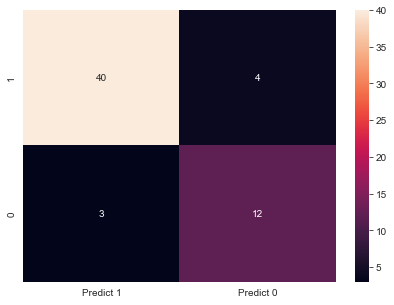

Accuracy of model is 0.881
f1_score for model is 0.92
precision for model is 0.93
Recall for model is 0.909
roc_auc_score for model is 0.8545
********************


In [72]:
#checking confusion matrix
recall_list=[]
precision_list=[]
f1_score_list=[]
roc_auc_list=[]
score_list=[]
model_name_list=[]
elapsed=[]
Model_evaluation =pd.DataFrame
TP_list=[]
FP_list=[]
FN_list=[]
TN_list=[]


classfierdict={'model': [StackingClassifier(estimators=list_of_models, final_estimator=LogisticRegression(), cv=10),
                         GaussianNB(),
                         LogisticRegression(solver='liblinear'),
                         KNeighborsClassifier(n_neighbors=3,weights='distance'),
                         SVC(C=20, kernel='rbf',probability=True),
                         RandomForestClassifier(max_features= max_features, min_samples_leaf= min_samples_leaf, n_estimators=n_estimators, random_state=random_state),
                         GradientBoostingClassifier(n_estimators = 50,random_state=1)]}


for model in classfierdict['model']:
    start = time.time()
    model.fit(X_train_v1, y_train_v1)
    y_pred = model.predict(X_test_v1)
    cm=metrics.confusion_matrix(y_test_v1, y_pred, labels=[1, 0])
    df_cm = pd.DataFrame(cm, index = [j for j in ["1","0"]],columns = [j for j in ["Predict 1","Predict 0"]])
    plt.figure(figsize = (7,5))
    print("Confusion Matrix of ",model)
    sns.heatmap(df_cm, annot=True,fmt='g',annot_kws={"fontsize":10})
    plt.show()
    TP=cm[0][0]
    FN=cm[0][1]
    FP=cm[1][0]
    TN=cm[1][1]

    accuracy_score= round(metrics.accuracy_score(y_test_v1, y_pred),3)
    print("Accuracy of model is",accuracy_score)
    f1_score= round(metrics.f1_score(y_test_v1, y_pred),3)
    print("f1_score for model is", f1_score)
    precision= round(metrics.precision_score(y_test_v1, y_pred),3)
    print("precision for model is", precision)
    recall= round(metrics.recall_score(y_test_v1, y_pred),3)
    print("Recall for model is" ,recall)
    roc_auc_score= round(metrics.roc_auc_score(y_test_v1, y_pred),4)
    print("roc_auc_score for model is" ,roc_auc_score)
    print("********************")
    
    score = round(model.score(X_test_v1, y_test_v1), 3) 
    recall=metrics.recall_score(y_test_v1, y_pred)
    precision=metrics.precision_score(y_test_v1, y_pred)
    f1_score=round(metrics.f1_score(y_test_v1, y_pred),3)
    probas_ = model.fit(X_train_v1, y_train_v1).predict_proba(X_test_v1)
    fpr, tpr, thresholds = roc_curve(y_test_v1, probas_[:, 1])
    
    roc_auc=round(auc(fpr, tpr),3)
    score_list.append(score)
    model_name_list.append(model)
    recall_list.append(recall)
    precision_list.append(precision)
    f1_score_list.append(f1_score)
    fpr, tpr, thresholds = roc_curve(y_test_v1, probas_[:, 1])
    roc_auc_list.append(roc_auc)
    TP_list.append(TP)
    FP_list.append(FP)
    FN_list.append(FN)
    TN_list.append(TN)
    end = time.time()
    duration = end - start
    elapsed.append(duration)
    
    Model_evaluation = pd.DataFrame({'Model':model_name_list,
                                   'Model_score':score_list,
                                   'Model_recall':recall_list,
                                   'Model_precision':precision_list,
                                   'Model_f1_score':f1_score_list,
                                   'Model_roc_auc':roc_auc_list,
                                   'False Negative':FN_list,
                                   'False Positive':FP_list,  
                                   'Elapsed': elapsed})
    Model_evaluation ['Model_name']= Model_evaluation ['Model'].astype('str').map(lambda x:re.sub("[\(\[].*?[\)\]]", "", x))
    
    
  

In [74]:
# Model Comparison
Model_evaluation.sort_values('Model_roc_auc')

,Model,Model_score,Model_recall,Model_precision,Model_f1_score,Model_roc_auc,False Negative,False Positive,Elapsed,Model_name
1,GaussianNB(),0.62700,0.50000,1.00000,0.66700,0.85200,22,0,0.22333,GaussianNB
2,LogisticRegression(solver='liblinear'),0.74600,0.70455,0.93939,0.80500,0.87400,13,2,0.28391,LogisticRegression
5,"(DecisionTreeClassifier(max_features=5, min_sa...",0.88100,0.93182,0.91111,0.92100,0.93800,3,4,0.81541,"RandomForestClassifier(max_features=5, min_sam..."
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.88100,0.90909,0.93023,0.92000,0.94100,4,3,0.41717,GradientBoostingClassifier
3,"KNeighborsClassifier(n_neighbors=3, weights='d...",0.88100,0.90909,0.93023,0.92000,0.94300,4,3,0.25130,KNeighborsClassifier
4,"SVC(C=20, probability=True)",0.88100,0.95455,0.89362,0.92300,0.94400,2,5,0.28638,SVC
0,"StackingClassifier(cv=10,\n ...",0.91500,0.97727,0.91489,0.94500,0.95300,1,4,2.88305,"StackingClassifier(cv=10,\n ..."


Summary:

1.	After comparing all the models based on AUC, we can see that Stacking model is performing well.
2.	Stacking model has an AUC of 95% with accuracy of 92% and f1-score of 0.945. Stacking has performed well in identifying True Positive and True Negative with very less False Negative.
3.	Getting patients identifying correctly for further treatment is very important in this case, this is where this model performs best considering good accuracy ad AUC Stacking is best classifier in this case.
4.	SVM and KNN too have shown good performance, but also more False Negative compared to stacking.
5.	Random Forest too has performed well within both target classes. But has more FN than stacking. This model might work better with more data
6.	This data had imbalanced classed with skewed data and multicollinearity due to which Logistic regression seems to be affected.
7.	In this case since target classes were clustered in different pockets, Non-linear models seems to have performed well